In [1]:
import os, sys, re
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
import pandas as pd
import numpy as np
from numpy import argmax
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib
import matplotlib
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
import plotly
import plotly.graph_objs as go

In [2]:
init_notebook_mode(connected=True) # Plotly needs this line to initialize local plotting

In [3]:
base_dir = os.path.join(os.environ["HOME"], "Desktop", "WF")

## Analyze Data

In [4]:
df = pd.read_csv(os.path.join(base_dir, "CFPB-Data.csv"), parse_dates=[0, 13], infer_datetime_format=True)
df.head(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2017-03-04,Bank account or service,Checking account,"Account opening, closing, or management",NaN,My wife and I visited the Chase Bank branch at...,NaN,JPMORGAN CHASE & CO.,KY,423XX,NaN,Consent provided,Web,2017-03-04,Closed with explanation,Yes,Yes,2371744
1,2017-04-12,Bank account or service,Checking account,Problems caused by my funds being low,NaN,I have documentation that shows that US Bank w...,Company has responded to the consumer and the ...,U.S. BANCORP,CA,928XX,NaN,Consent provided,Web,2017-04-12,Closed with explanation,Yes,No,2431565
2,2017-03-04,Credit card,NaN,Balance transfer,NaN,Around XX/XX/XXXX I accepted a credit card off...,NaN,JPMORGAN CHASE & CO.,TN,376XX,Older American,Consent provided,Web,2017-03-04,Closed with monetary relief,Yes,No,2371616
3,2017-04-14,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,Regarding PMI : we paid up front at closing to...,Company has responded to the consumer and the ...,"WELLS FARGO BANK, NATIONAL ASSOCIATION",TX,750XX,NaN,Consent provided,Web,2017-04-14,Closed with explanation,Yes,No,2436277
4,2017-04-08,Consumer Loan,Vehicle lease,Taking out the loan or lease,NaN,I have leased a vehicle XX/XX/2015 from an aut...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,CA,926XX,NaN,Consent provided,Web,2017-04-08,Closed with explanation,Yes,No,2426136


In [5]:
df["Issue"].groupby(df["Issue"]).count() # Checking the distribution by Issue

Issue
APR or interest rate                         414
Account opening, closing, or management     4392
Account terms and changes                      3
Adding money                                   2
Advertising and marketing                    435
Advertising, marketing or disclosures          5
Application processing delay                  51
Application, originator, mortgage broker    1462
Applied for loan/did not receive money        13
Arbitration                                   40
Balance transfer                             167
Balance transfer fee                          35
Bankruptcy                                    43
Billing disputes                            1551
Billing statement                            334
Can't contact lender                          10
Can't repay my loan                          172
Can't stop charges to bank account             2
Cash advance                                  21
Cash advance fee                              23
Charged bank a

In [6]:
df["Company"].groupby(df["Company"]).count() # Checking the distribution by Company

Company
ALLY FINANCIAL INC.                        823
BANK OF AMERICA, NATIONAL ASSOCIATION     7196
BB&T CORPORATION                           614
CIT BANK, NATIONAL ASSOCIATION             131
CITIBANK, N.A.                            6953
CITIZENS FINANCIAL GROUP, INC.             586
CITY NATIONAL BANK                           9
FIFTH THIRD FINANCIAL CORPORATION          465
JPMORGAN CHASE & CO.                      6035
PNC Bank N.A.                             1155
REGIONS BANK                               364
SUNTRUST BANKS, INC.                       860
TD BANK US HOLDING COMPANY                1070
U.S. BANCORP                              2200
WELLS FARGO BANK, NATIONAL ASSOCIATION    7436
Name: Company, dtype: int64

### Plot distribution of complaints over time

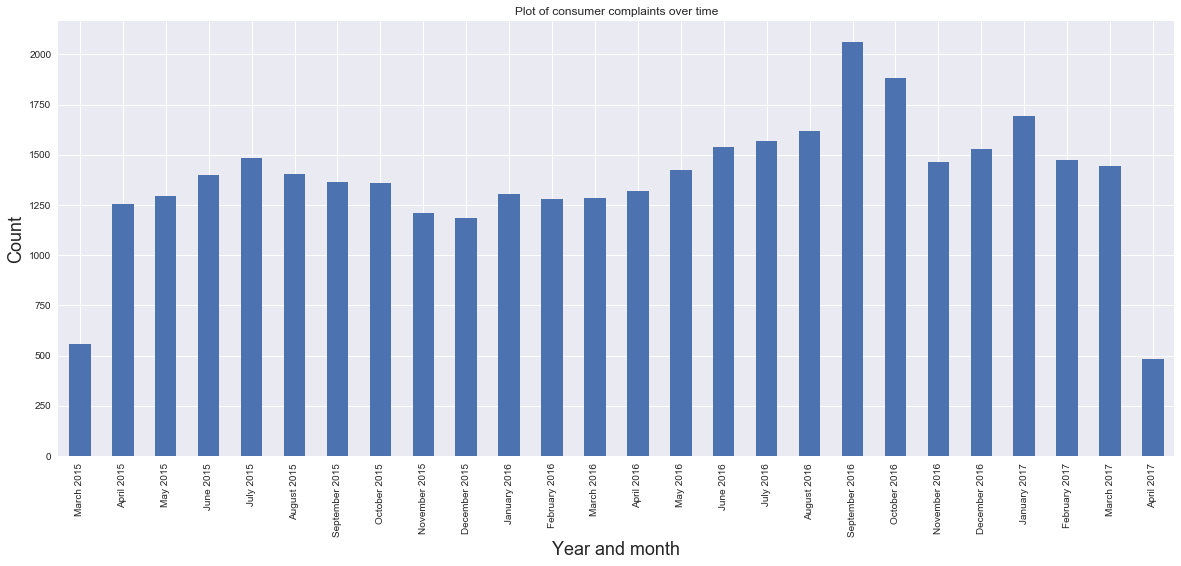

In [7]:
plt.clf()
date_received = df["Date received"]
grouped_by_month = date_received.groupby([date_received.dt.year, date_received.dt.month])
axes = grouped_by_month.count().plot(kind="bar", figsize=(20, 8), title="Plot of consumer complaints over time")
axes.set_xlabel("Year and month", fontsize=18)
axes.set_ylabel("Count", fontsize=18)
axes.set_xticklabels([datetime.date(x[0],x[1],1).strftime("%B %Y") for x in grouped_by_month.groups.keys()])
plt.show()

### Plot distribution of complaints vs bank in the late 2016 time frame where there is a spike

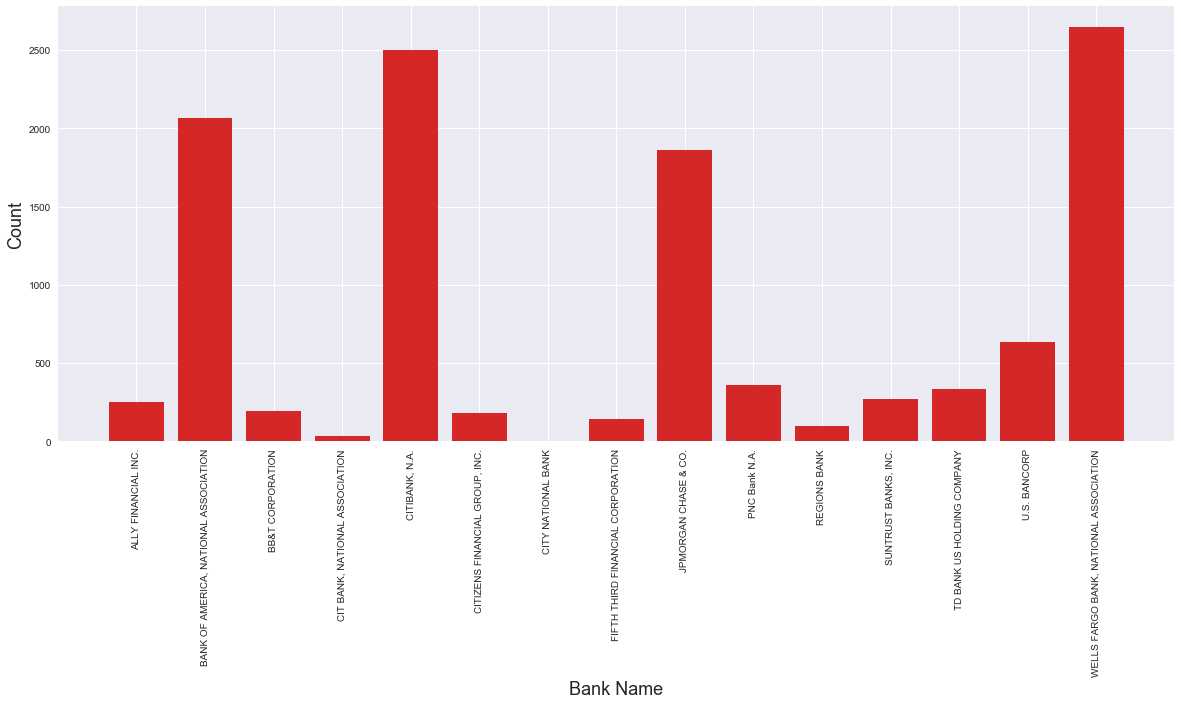

In [8]:
plt.clf()
late_2016_data = df[ (df["Date received"] > '2016-06-01') & (df["Date received"] < '2016-12-31') ]
groupby_company = late_2016_data["Company"].groupby(late_2016_data["Company"])
count = groupby_company.count()
fig, ax = plt.subplots(figsize=(20,8))
plt.bar(np.arange(15), count, color='#d62728')
ax.set_xticks(np.arange(15)) #If this line is absent all tick labels are not set
ax.set_xticklabels(groupby_company.groups, rotation=90)
ax.set_xlabel("Bank Name", fontsize=18)
ax.set_ylabel("Count", fontsize = 18)
plt.show()

In [9]:
# A utility method to print the top words in a topic model
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

### Model creation

In [10]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=10, stop_words='english')

In [11]:
# Regex for cleaning up data such as XXXX and {$300} etc
ignore_pattern = re.compile("[\(\{](.*?)[\)\}]|[X]+")

In [12]:
text = df["Consumer complaint narrative"].iloc[182]
for m in ignore_pattern.finditer(text):
    print('%02d-%02d: %s' % (m.start(), m.end(), m.group(0)))

38-51: ( {$13000.00}
54-58: XXXX
133-137: XXXX
194-204: {$5000.00}
410-414: XXXX
423-435: ( {$9000.00}
471-475: XXXX
484-496: ( {$4000.00}
524-528: XXXX
561-565: XXXX
615-617: XX
618-620: XX
914-924: {$5000.00}
938-983: ( a one to one transfer from XXXX to B of A )
999-1003: XXXX
1185-1189: XXXX
1914-1918: XXXX


In [13]:
#wells_fargo_df = df[ df["Company"] == "WELLS FARGO BANK, NATIONAL ASSOCIATION" ]
# Only interested in Wells Fargo data
df = df[ df["Company"] == "WELLS FARGO BANK, NATIONAL ASSOCIATION" ]

In [14]:
# Vectorizing the data with counts
scrubbed_text = [ ignore_pattern.sub("", text) for text in df["Consumer complaint narrative"] ]
tf = tf_vectorizer.fit_transform(scrubbed_text)

In [15]:
# Initializing the LDA model
n_topics = 50
'''
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=100,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
'''
lda = joblib.load(os.path.join(base_dir, "pickle", "sklearn_topics-wf-only-50.pkl"))

In [16]:
#transformed = lda.fit_transform(tf)
transformed = lda.transform(tf)

In [18]:
#joblib.dump(lda, os.path.join(base_dir, "pickle", "sklearn_topics-1.pkl")) 

['/Users/singhv/Desktop/WF/pickle/sklearn_topics-1.pkl']

In [17]:
tf_feature_names = tf_vectorizer.get_feature_names()

In [18]:
n_top_words = 20
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
account fargo wells branch opened close charges manager asked total online charged closed told clearly hold loan remove credit quite
Topic #1:
wfb conversion note mortgage loan wells foreclose rejected fargo trust wf home perfect transferred value relevant account appraisal property 2nd
Topic #2:
clear thousand incurred mistake letterhead decisions unfairly focus nature mismanagement 3rd reputable dozens asked pending victims delinquent processed updating truth
Topic #3:
account fargo wells years irs wfhm home provided review close time sale intentions stop date agent entry submitted month know
Topic #4:
photo quite renovation beg recognized happens unpaid alot handed maintained frankly easier based meet future producing appearing water collected release
Topic #5:
environment loan home payments modification requested mortgage bank denied want did company just make information account months income pay mod
Topic #6:
wells fargo bank loan money took pay auto modification used w

In [30]:
#print(dict(zip(range(10), transformed[0])))
print(len(transformed))
print(transformed[0])

7436
[  3.77358491e-04   3.77358491e-04   3.77358491e-04   3.77358491e-04
   3.77358491e-04   3.77358491e-04   3.77358491e-04   3.77358491e-04
   4.38656828e-01   3.77358491e-04   3.77358491e-04   3.77358491e-04
   3.77358491e-04   3.77358491e-04   3.77358491e-04   3.91189067e-02
   3.77358491e-04   3.77358491e-04   3.77358491e-04   2.81492505e-01
   3.77358491e-04   3.77358491e-04   3.77358491e-04   3.77358491e-04
   3.77358491e-04   3.77358491e-04   3.77358491e-04   1.50889205e-01
   3.77358491e-04   3.77358491e-04   3.77358491e-04   4.55330677e-02
   3.77358491e-04   3.77358491e-04   3.77358491e-04   3.77358491e-04
   3.77358491e-04   3.77358491e-04   2.77057140e-02   3.77358491e-04
   3.77358491e-04   3.77358491e-04   3.77358491e-04   3.77358491e-04
   3.77358491e-04   3.77358491e-04   3.77358491e-04   3.77358491e-04
   3.77358491e-04   3.77358491e-04]


In [19]:
# Setting the Top Topic to the topic with the highest weight
df["Top Topic"] = [np.argmax(x) for x in transformed]

In [20]:
# Grouping complaints based upon timeframe (month)
wf_topics_grouped_by_time = df["Top Topic"].groupby([df['Date received'].dt.year, df["Date received"].dt.month])

In [21]:
# temp is a list of Series objects containing the count of Top Topics for the timeframes from above
temp = []
for i, group_name in enumerate(wf_topics_grouped_by_time.groups.keys()):
    group = wf_topics_grouped_by_time.get_group(group_name)
    count = group.groupby(group).count()
    temp.append(count) 

In [22]:
# z contains one list for every topic id. Every list contains the distribution of the topic over months
z = []
for topic_id in range(n_topics):
    topic_counts = [x.get(topic_id, 0) for x in temp]
    z.append(topic_counts)
    
#print(z)

### Heatmap for visualizing topics over time

In [23]:
data = [
    go.Heatmap(
        z=z,
        x=[datetime.date(x[0],x[1],1) for x in wf_topics_grouped_by_time.groups.keys()], # np.arange(len(wf_topics_grouped_by_time.groups.keys())),
        y=["Topic %d" % i for i in np.arange(n_topics)],
        colorscale='Viridis',
    )
]

In [24]:
layout = go.Layout(
    title='Topic distribution over time',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' )
)

In [25]:
fig = go.Figure(data=data, layout=layout)
iplot(fig)

### Bar chart showing the same data as above

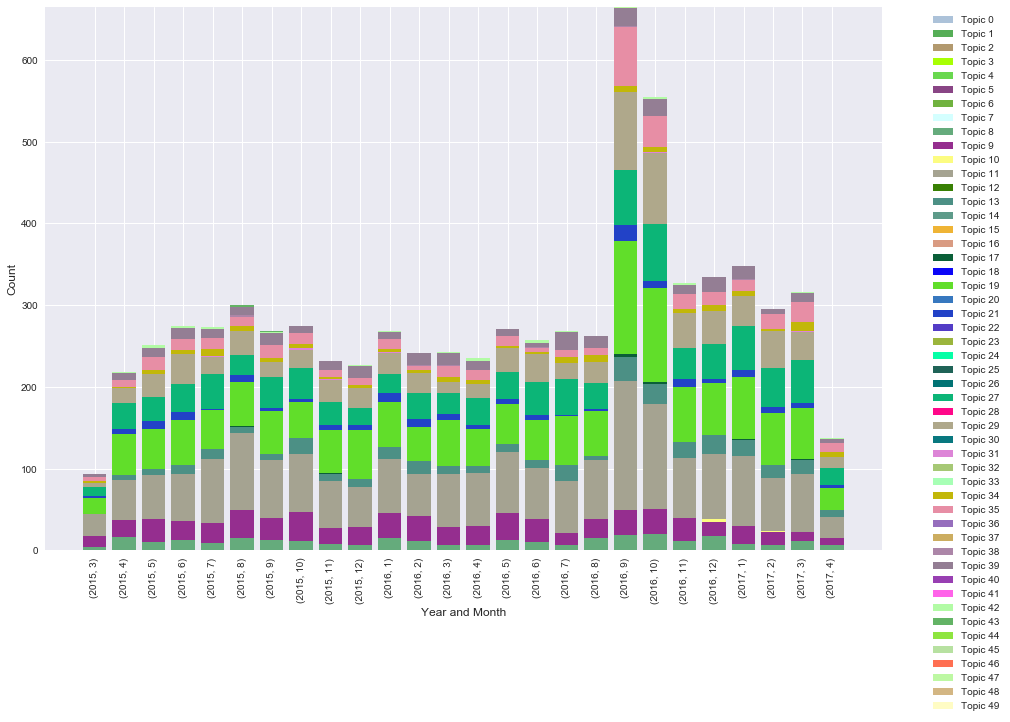

In [26]:
plt.clf()
temp = []
for group_name in wf_topics_grouped_by_time.groups.keys():
    group = wf_topics_grouped_by_time.get_group(group_name)
    count = group.groupby(group).count()
    temp.append(count)

fig, ax = plt.subplots(figsize=(15, 10))
colors = list(matplotlib.colors.get_named_colors_mapping().keys())[:n_topics]

bottom = np.zeros(len(temp), dtype=np.int)
for topic_id in range(n_topics):
    bottom += topic_counts if topic_id > 0 else np.zeros(len(temp), dtype=np.int)
    topic_counts = [x.get(topic_id, 0) for x in temp]
    plt.bar(np.arange(len(temp)), topic_counts, bottom=bottom, color = colors[topic_id], label='Topic %d' %topic_id)

ax.set_xticks(np.arange(len(wf_topics_grouped_by_time)))
ax.set_xticklabels(list(wf_topics_grouped_by_time.groups.keys()), rotation=90)
ax.set_xlabel("Year and Month", fontsize='medium')
ax.set_ylabel("Count", fontsize='medium')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

In [27]:
# temp is a list of Series objects containing the count of Top Topics for the timeframes from above
temp = []
for i, group_name in enumerate(wf_topics_grouped_by_time.groups.keys()):
    group = wf_topics_grouped_by_time.get_group(group_name)
    count = group.groupby(group).count()
    temp.append(count) 

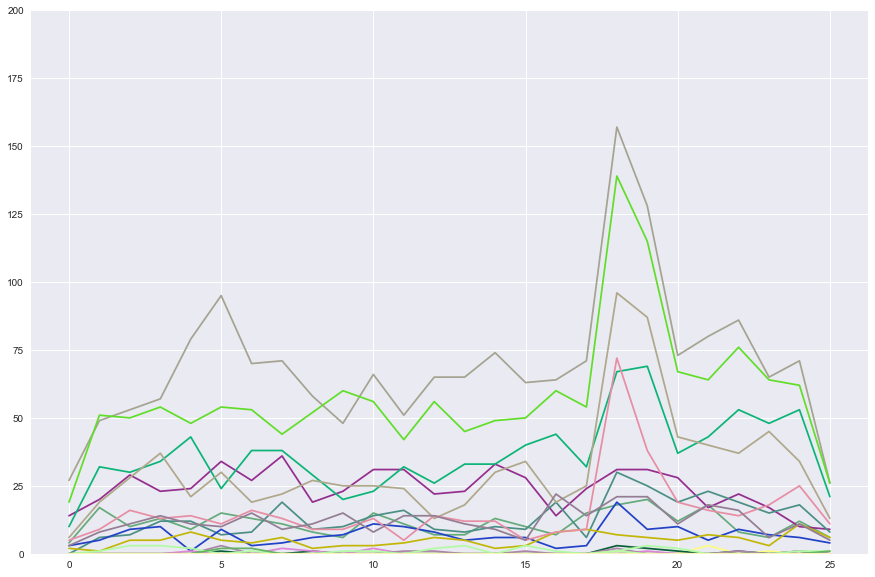

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_ylim(top = 200)
colors = list(matplotlib.colors.get_named_colors_mapping().keys())[:n_topics]
for topic_id in range(n_topics):
    topic_over_time = [x.get(topic_id, 0) for x in temp]
    plt.plot(np.arange(len(topic_over_time)), topic_over_time, color=colors[topic_id])
plt.show()

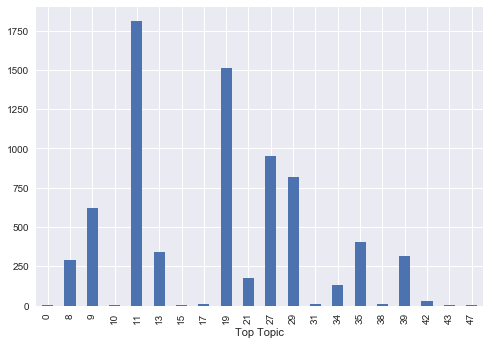

In [29]:
df["Top Topic"].groupby(df["Top Topic"]).count().plot(kind="bar")
plt.show()

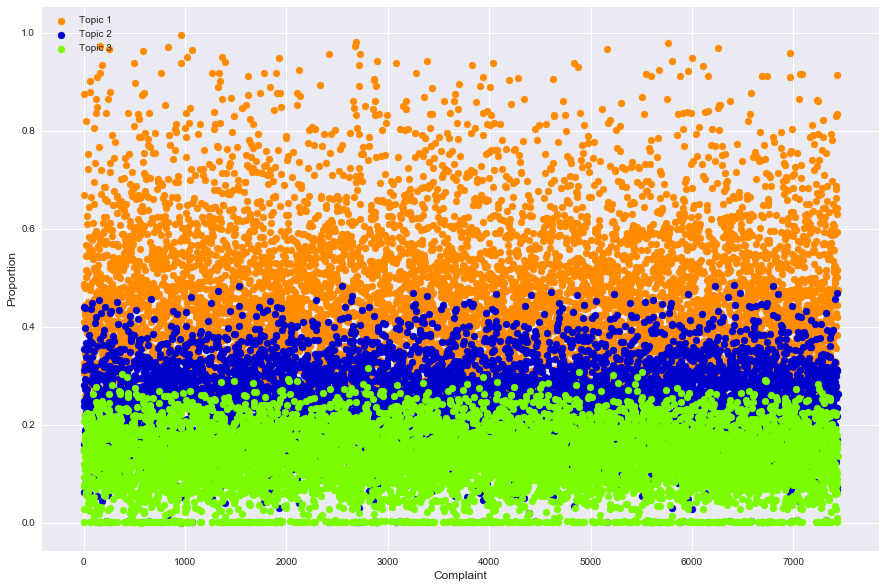

In [30]:
plt.clf()
fig, ax = plt.subplots(figsize=(15, 10))
transformed_sorted = [np.sort(x) for x in transformed]
plt.scatter(np.arange(len(transformed)), [x[-1] for x in transformed_sorted], color='darkorange', label="Topic 1")
plt.scatter(np.arange(len(transformed)), [x[-2] for x in transformed_sorted], color='mediumblue', label="Topic 2")
plt.scatter(np.arange(len(transformed)), [x[-3] for x in transformed_sorted], color='lawngreen', label="Topic 3")
plt.legend(loc='upper left')
ax.set_xlabel("Complaint", fontsize='medium')
ax.set_ylabel("Proportion", fontsize='medium')
plt.show()

In [31]:
unique_issues = df["Issue"].unique()
issues_to_id = dict( zip(unique_issues, np.arange(unique_issues.size, dtype=np.int16)) ) 
df["Issue Id"] = pd.Series( [issues_to_id[id_] for id_ in df["Issue"]], dtype=np.int16  )
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Top Topic,Issue Id
3,2017-04-14,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,Regarding PMI : we paid up front at closing to...,Company has responded to the consumer and the ...,"WELLS FARGO BANK, NATIONAL ASSOCIATION",TX,750XX,NaN,Consent provided,Web,2017-04-14,Closed with explanation,Yes,No,2436277,8,3.0
8,2017-03-23,Consumer Loan,Pawn loan,Applied for loan/did not receive money,NaN,Several years ago I got a line of credit loan ...,Company has responded to the consumer and the ...,"WELLS FARGO BANK, NATIONAL ASSOCIATION",PA,182XX,Servicemember,Consent provided,Web,2017-03-23,Closed with explanation,Yes,No,2401871,8,7.0
15,2017-04-06,Mortgage,FHA mortgage,"Loan modification,collection,foreclosure",NaN,I do not feel I 've been getting fair opportun...,Company has responded to the consumer and the ...,"WELLS FARGO BANK, NATIONAL ASSOCIATION",MD,207XX,NaN,Consent provided,Web,2017-04-06,Closed with explanation,Yes,No,2420235,9,11.0
16,2017-03-11,Consumer Loan,Installment loan,Taking out the loan or lease,NaN,On behalf of my dad XXXX who is XXXX years of ...,Company has responded to the consumer and the ...,"WELLS FARGO BANK, NATIONAL ASSOCIATION",NJ,086XX,NaN,Consent provided,Web,2017-03-14,Closed with explanation,Yes,No,2382679,11,4.0
17,2017-04-12,Bank account or service,Checking account,"Account opening, closing, or management",NaN,On XX/XX/XXXX our XXXX of XXXX.. passed away. ...,Company has responded to the consumer and the ...,"WELLS FARGO BANK, NATIONAL ASSOCIATION",MD,206XX,NaN,Consent provided,Web,2017-04-13,Closed with explanation,Yes,No,2430838,19,12.0


In [32]:
temp = []
grouped_by_issue = df["Top Topic"].groupby(df["Issue"])
for issue in df["Issue"].unique():
    group = grouped_by_issue.get_group(issue)
    count = group.groupby(group).count()
    temp.append(count)
    
print(len(temp))

76


In [33]:
z = []
for topic_id in range(n_topics):
    topic_counts = [x.get(topic_id, 0) for x in temp]
    z.append(topic_counts)

In [34]:
data = [
    go.Heatmap(
        z=z,
        x=df["Issue"].unique(), # np.arange(len(wf_topics_grouped_by_time.groups.keys())),
        y=["Topic %d" % i for i in np.arange(n_topics)],
        colorscale='Viridis',
    )
]

In [35]:
layout = go.Layout(
    title='Topic Issue Correlation',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' )
)

In [36]:
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [52]:
df[ (df["Issue"] == "Wrong amount charged or received") & (df["Top Topic"] == 19) ]

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Top Topic,Issue Id
13659,2017-02-08,Money transfers,International money transfer,Wrong amount charged or received,NaN,Attached are copies of 1 ) XXXX XXXX Wire Tran...,Company has responded to the consumer and the ...,"WELLS FARGO BANK, NATIONAL ASSOCIATION",MD,208XX,Older American,Consent provided,Web,2017-03-02,Closed with explanation,No,Yes,2334272,19,NaN
14421,2015-12-04,Money transfers,International money transfer,Wrong amount charged or received,NaN,I needed money while living XXXX in XXXX to pa...,Company chooses not to provide a public response,"WELLS FARGO BANK, NATIONAL ASSOCIATION",TX,776XX,NaN,Consent provided,Web,2015-12-04,Closed with explanation,Yes,Yes,1683918,19,NaN
28856,2016-04-25,Money transfers,International money transfer,Wrong amount charged or received,NaN,I used Wells Fargo to do a wire transfer of XX...,Company has responded to the consumer and the ...,"WELLS FARGO BANK, NATIONAL ASSOCIATION",CA,941XX,NaN,Consent provided,Web,2016-04-25,Closed with monetary relief,Yes,No,1895511,19,NaN
33801,2017-02-07,Money transfers,Domestic (US) money transfer,Wrong amount charged or received,NaN,I wired Wells Fargo a large sum of money to at...,Company has responded to the consumer and the ...,"WELLS FARGO BANK, NATIONAL ASSOCIATION",TX,752XX,NaN,Consent provided,Web,2017-02-07,Closed with explanation,No,Yes,2331702,19,NaN


In [20]:
topic_words = "modification loan home wells fargo sale mortgage foreclosure documents income process review short denied received assistance property date submitted request".split()
topic_verbs = [x for x in topic_words if x.endswith("d")]
print(topic_verbs)

['denied', 'received', 'submitted']


In [21]:
phrases = []
for narrative in df[ df["Top Topic"] == 11 ]["Consumer complaint narrative"]:
    sentences = nltk.sent_tokenize(narrative)
    for sent in sentences:
        words = nltk.word_tokenize(sent)
        for verb in topic_verbs:
            if verb in words:
                idx = words.index(verb)
                start_idx = (idx - 2) if (idx >= 2) else 0
                end_idx = (idx + 2) if (idx <= len(words) - 3) else -1
                phrase = " ".join(words[start_idx : end_idx])
                phrases.append(phrase)
                
print(phrases)

['XX/XX/XXXX I received a', 'XX/XX/XXXX I received a', 'I received another', 'we were denied and', 'everything I received {', ', I submitted a', 'funds they received ...', 'I received a', 'I received my', 'and they denied me', 'WELLS FARGO submitted a', 'I not received any', 'years and received a', '> I submitted a', 'XXXX were denied by', ', I submitted all', 'I was denied because', ', I received a', 'was still denied and', 'company just denied ,', 'and were denied', 'online and received the', 'however XXXX denied the', 'case was submitted XX/XX/XXXX', 'documents were received', 'XXXX I received call', 'I never received', ', they submitted a', ', we received letter', 'back , received paperwork', 'we finally received a', 'day I received a', 'month I received a', 'I have received more', 'major bank received deposit', 'Today I received a', 'claim was denied', '2016 I received all', 'time I received a', 'time he denied the', 'XXXX XXXX denied the', 'I just received another', 'that they re

In [16]:
bank_mention_count = 0
bank_regex = re.compile("bank|wells fargo", re.IGNORECASE)
for narrative in df["Consumer complaint narrative"]:
    bank_mention_count += 1 if bank_regex.search(narrative) else 0
                
print(bank_mention_count)

6725


In [17]:
import json
from watson_developer_cloud import AlchemyLanguageV1

In [24]:
text = df[ df["Complaint ID"] == 2427827 ]["Consumer complaint narrative"].any()

In [29]:
API_KEY = "e0759019e81f7776b95cbebf8b2f2ffe0244a3f9"
alchemy_language = AlchemyLanguageV1(api_key=API_KEY)
print(alchemy_language.emotion(text = text).get("docEmotions"))

{'anger': '0.141183', 'disgust': '0.06162', 'fear': '0.099397', 'joy': '0.112048', 'sadness': '0.505061'}


In [32]:
df.iloc[2:5]["Consumer complaint narrative"]

15    I do not feel I 've been getting fair opportun...
16    On behalf of my dad XXXX who is XXXX years of ...
17    On XX/XX/XXXX our XXXX of XXXX.. passed away. ...
Name: Consumer complaint narrative, dtype: object

In [35]:
emotions = []
for narrative in df.iloc[:5]["Consumer complaint narrative"]:
    response = alchemy_language.emotion(text = narrative)
    #print(response)
    if (response is not None) and (response.get("status") == "OK"):
        emotions.append(response.get("docEmotions"))
    else:
        emotions.append("NA")

print(emotions)

[{'anger': '0.114281', 'disgust': '0.052268', 'fear': '0.006448', 'joy': '0.005096', 'sadness': '0.210604'}, {'anger': '0.151716', 'disgust': '0.02584', 'fear': '0.033643', 'joy': '0.098483', 'sadness': '0.703463'}, {'anger': '0.088706', 'disgust': '0.053114', 'fear': '0.08577', 'joy': '0.058228', 'sadness': '0.124554'}, {'anger': '0.166394', 'disgust': '0.038223', 'fear': '0.089113', 'joy': '0.05349', 'sadness': '0.221806'}, {'anger': '0.113021', 'disgust': '0.057998', 'fear': '0.085546', 'joy': '0.089326', 'sadness': '0.554845'}]
